In [105]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

In [138]:
df = pd.read_csv("data/TESLA/TSLA.csv")
df["Date"]=pd.to_datetime(df.Date,dayfirst=True)
df.set_index("Date",inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2843 entries, 2010-07-01 to 2021-10-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2843 non-null   float64
 1   High       2843 non-null   float64
 2   Low        2843 non-null   float64
 3   Close      2843 non-null   float64
 4   Adj Close  2843 non-null   float64
 5   Volume     2843 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 155.5 KB


In [295]:
X = np.array([df.values[i - 30 : i, 1] for i in range(30, 2843-5)])
Y = np.array([df.values[i + 1 : i + 6, 1] for i in range(30, 2843-5)])

In [296]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=44)

<AxesSubplot: xlabel='Date'>

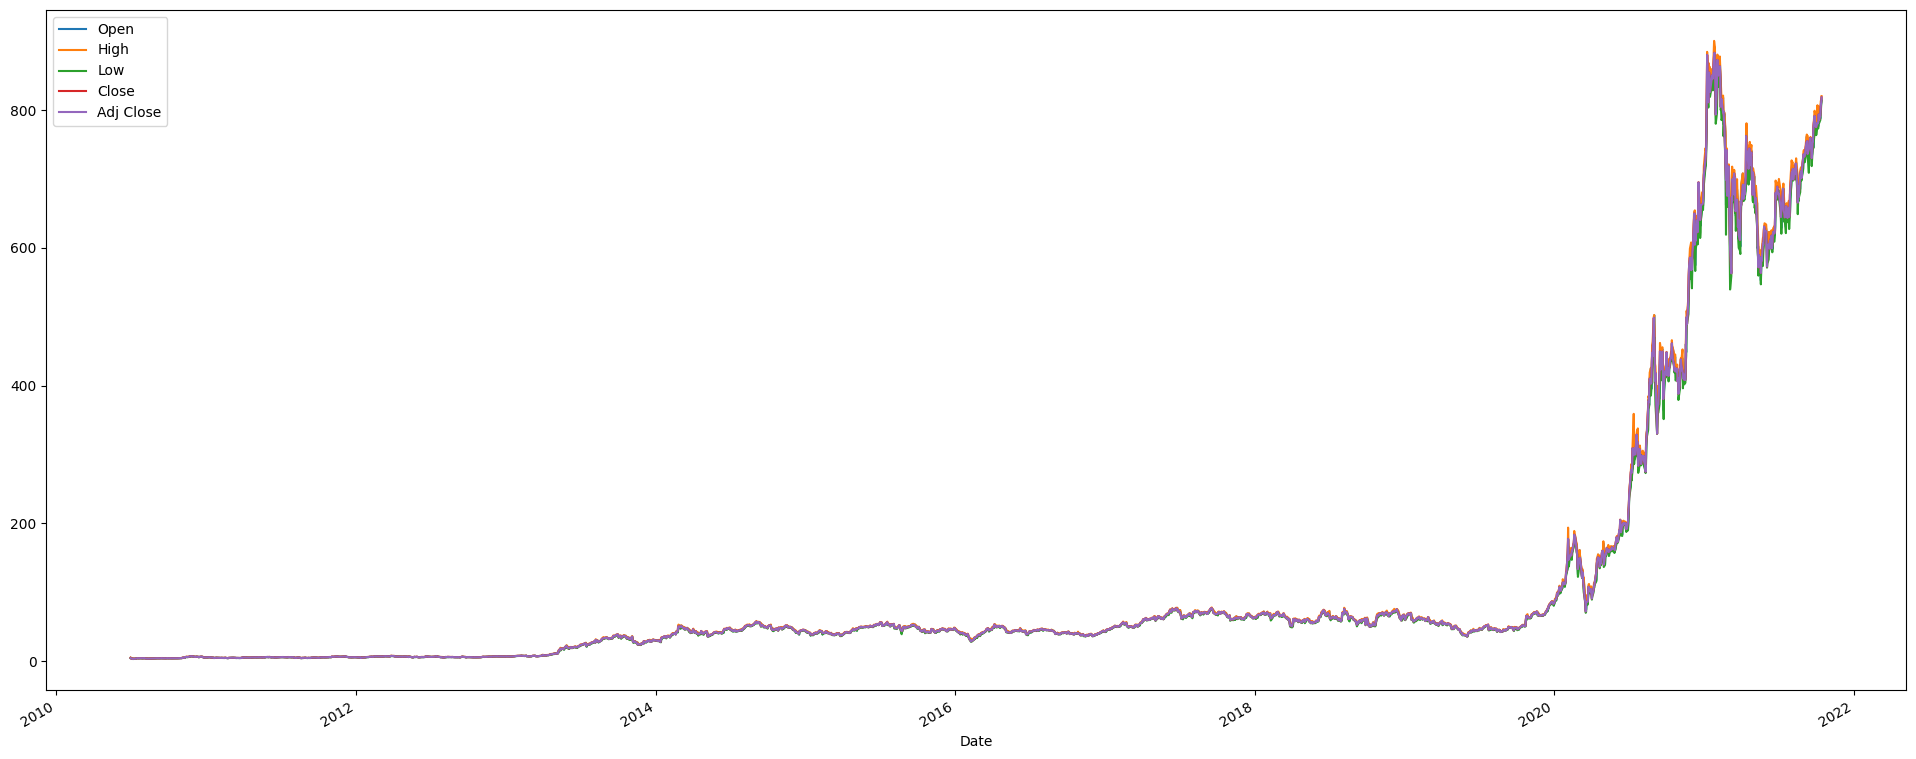

In [134]:
df.drop(columns=['Volume']).plot(figsize=(24,10))

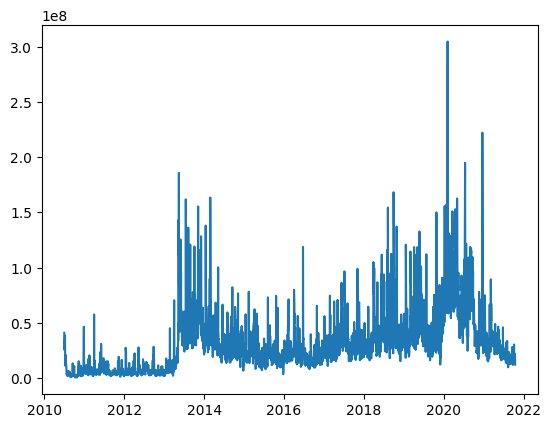

In [136]:
plt.plot(df['Volume'])

In [100]:
class C_means:
    def __init__(self, clustersNumber: int, axesNumber: int, std: float = 1) -> None:
        self.Weights = np.random.random((clustersNumber, axesNumber))
        self.Std = std

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.predict(x)

    def __Gauss(self, x: np.ndarray, std: float = 1, mean: float = 0) -> np.ndarray:
        return 1 / (std * (2 * np.pi)**0.4)*np.exp(-0.5 * ((x - mean) / std)**2)

    def __R(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return np.sum((x[:, None, :] - y[None, :, :])**2, axis=2)**0.5
    
    def __Loss(self, x: np.ndarray, c: np.ndarray, r: np.ndarray) -> np.ndarray:
        return (r * self.__R(x, c)**2).sum()
    
    def __GetMembershipMatrix(self, x: np.ndarray) -> np.ndarray:
        d = self.__R(x, self.Weights)
        N = self.__Gauss(d, self.Std)
        r = N/np.sum(N, axis=1)[:, None]
        return r

    def fit(self, x: np.ndarray) -> None:
        x /= x.max(0)
        r = self.__GetMembershipMatrix(x)
        J = self.__Loss(x, self.Weights, r)
        while(True):
            r = self.__GetMembershipMatrix(x)
            newWeights = (x[:, None, :] * r[:, :, None]).sum(0) / r.sum(0)[:, None]
            Jn = self.__Loss(x, newWeights, r)
            if(np.abs(J-Jn)<=1e-9):
                break
            else:
                self.Weights = newWeights
                J = Jn

    def predict(self, x: np.ndarray) -> np.ndarray:
        x /= x.max(0)
        r = self.__GetMembershipMatrix(x)
        return r

In [252]:
class Linear:
    def __init__(self, inputSize: int, outputSize: int) -> None:
        self.Weights: np.ndarray = np.random.random((inputSize, outputSize))
        self.__last: np.ndarray = None

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.predict(x)
    
    def fit(self, loss: np.ndarray, lr: float = 0.01) -> np.ndarray:
        weights = self.Weights
        self.Weights -= lr * self.__last[:, None] * loss[None, :]
        return loss @ np.linalg.pinv(weights)

    def predict(self, x: np.ndarray) -> np.ndarray:
        self.__last = x
        return x @ self.Weights

In [227]:
class MSE:
    def __init__(self) -> None:
        self.__expected: np.ndarray = None
        self.__predicted: np.ndarray = None

    def __call__(self, Y_p: np.ndarray, Y_e: np.ndarray) -> np.ndarray:
        return self.predict(Y_p, Y_e)

    def predict(self, Y_p: np.ndarray, Y_e: np.ndarray) -> np.ndarray:
        self.__expected = Y_e
        self.__predicted = Y_p
        return ((Y_p - Y_e)**2) / Y_p.size
        #return ((Y_p - Y_e)**2).sum(1) / Y_p.size
    
    def fit(self) -> np.ndarray:
        return 2 * (self.__predicted -  self.__expected)

In [189]:
class ReLU:
    def __init__(self) -> None:
        self.__last: np.ndarray = None

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.predict(x)

    def predict(self, x: np.ndarray) -> np.ndarray:
        self.__last = x >= 0
        return x * self.__last
    
    def fit(self, loss: np.ndarray) -> np.ndarray:
        return loss * self.__last

In [ ]:
X.shape

In [297]:
c_means = C_means(10, 30, 0.1)
c_means.fit(X_train.reshape(X_train.shape[0], 30))
r = c_means(X_train.reshape(X_train.shape[0], 30))

In [300]:
r.shape

(2106, 10)

In [308]:
X_train.max()

1.0

In [309]:
Y_train.max()

900.400024

In [310]:
Y_test.max()

884.48999

In [301]:
ll1 = Linear(10, 10)
relu = ReLU()
ll2 = Linear(10, 5)
mse = MSE()

for i in range(r.shape[0]):
    x = r[i]
    x = ll1(x)
    x = ll2(x)
    lose = mse(x, Y_train[i])
    res = mse.fit()
    res = ll2.fit(res)
    ll1.fit(res)

[397.32638752 358.99227394 312.86261386 348.767628   347.18603164]
[239.43837835 235.22086581 253.06707139 278.8227809  273.13620167]
[152147.59461526 137502.51649467 135365.22860014 135649.10912521
 148647.76792622]
[113453.6055801  115141.24575602 108790.9423979  107467.49581754
 107613.88950021]
[43374.38249607 47696.61908915 54880.26243507 59223.68883324
 62874.75923584]
[3588.38442433 3699.98722375 3958.90087028 4080.61027594 4167.19889618]
[8468.93662579 8510.32562117 8583.83068441 8596.35240166 8752.70127706]
[2151.2011845  2016.71619072 1912.15490608 1866.40566577 1965.57495426]
[2410.04655901 2437.37127216 2447.01987586 2444.02502065 2506.00451824]
[2267.61357695 2285.63383963 2278.96906679 2281.43596768 2315.6464454 ]
[3250.72269601 3391.26628709 3305.41673975 3297.19740093 3313.05728545]
[2124.56747013 2196.6766773  2132.96787048 2124.32738475 2172.88144318]
[1116.06785707 1211.05706744 1149.597885   1234.69385295 1358.55352482]
[336.54721804 361.48248606 346.7212334  406.16

In [303]:
r_test = c_means(X_test.reshape(X_test.shape[0], 30))
result = list()
for i in range(r_test.shape[0]):
    x = r_test[i]
    x = ll1(x)
    x = ll2(x)
    result.append(x)

In [304]:
loss = mse(np.array(result), Y_test)

In [306]:
loss.mean()

0.4022856831926011

In [5]:
def Conv2d(image: np.ndarray, kernel: np.ndarray, stride: int) -> np.ndarray:
    m, n = kernel.shape
    w, y, x = image.shape
    img = np.zeros((w, y+stride*2, x+stride*2))
    img[:, stride:y+stride, stride:x+stride] = image
    image = img
    new_image = np.zeros((w, y+stride*2-m+1,x+stride*2-n+1))
    for i in range(y+stride*2-m+1):
        for j in range(x+stride*2-n+1):
            new_image[:, i, j] = np.sum(image[:, i:i+m, j:j+n]*kernel, (1, 2))
    return new_image

In [6]:
def Diff2d(img: np.ndarray) -> np.ndarray:
    Scharr_y = np.array([[ 3,  10,  3],
                         [ 0,   0,  0],
                         [-3, -10, -3]])
    Scharr_x = np.array([[3,  0,  -3],
                         [10, 0, -10],
                         [3,  0,  -3]])
    img_x = Conv2d(img, Scharr_x, 2)
    img_y = Conv2d(img, Scharr_y, 2)
    return np.sqrt(img_x**2+img_y**2)

In [7]:
def Conv2d_diff(loss: np.ndarray, image: np.ndarray, kernel: np.ndarray, stride: int) -> np.ndarray:
    x = np.array([Conv2d(image[l][None,:,:], loss[l], stride) for l in range(loss.shape[0])])
    out = Conv2d(loss, kernel, stride)
    return x, out

In [8]:
def Linear(data: np.ndarray, weights: np.ndarray) -> np.ndarray:
    return data @ weights

In [9]:
def Linear_diff(loss: np.ndarray, data: np.ndarray, weights: np.ndarray) -> np.ndarray:
    return  data[:, :, None] * loss[:, None, :], loss @ np.linalg.pinv(weights)

In [10]:
def MSE(Y_p: np.ndarray, Y_e: np.ndarray) -> np.ndarray:
    return ((Y_p-Y_e)**2).sum(1)/Y_p.size

In [11]:
def MSE_diff(Y_p: np.ndarray, Y_e: np.ndarray) -> np.ndarray:
    return 2*(Y_p-Y_e)

In [12]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))
    
def anover_sigmoid(X):
    return np.exp(X) / (np.exp(X) + 1)
    
def stable_sigmoid(X):
    return sigmoid(X*(X >= 0))*(X >= 0) + anover_sigmoid(X*(X < 0))*(X < 0)

def Sigmoid(data: np.ndarray) -> np.ndarray:
    return stable_sigmoid(data)

In [13]:
def Sigmoid_diff(data: np.ndarray) -> np.ndarray:
    return Sigmoid(data)*(1-Sigmoid(data))

In [14]:
def Sigmoid_diff1(loss, data: np.ndarray) -> np.ndarray:
    return loss* data*(1-data)

In [15]:
def ReLU(data: np.ndarray) -> np.ndarray:
    return data*(data>0)

In [16]:
def ReLU_diff(data: np.ndarray) -> np.ndarray:
    return 1.*(data>0)
def ReLU_diff1(loss, data: np.ndarray) -> np.ndarray:
    return loss*(data>0)

In [ ]:
kernel = np.random.random((5,5))
weights1 = np.random.random((28**2, 1000))
weights2 = np.random.random((1000, 10))
def fit(image, kernel, weights1, weights2):
    x = Conv2d(data, kernel, 3)
    x = x.reshape((60, 28**2))
    x = Linear(x, weights1)
    x = Linear(x, weights2)
    xmax = np.abs(x).max()
    x4 = Sigmoid(x/xmax)
    x5 = MSE(x4, Y_e)
    l[i] = x5.sum()
    y1 = MSE_diff(x4, Y_e)
    y2 = Sigmoid_diff1(y1, x4)
    w, y3 = Linear_diff(y2, x2, weights)
    weights-=0.01*w.mean(0)
    y4 = y3.reshape((data.shape[0], 28, 28))
    k, _ = Conv2d_diff(y4, data, kernel, 3)
    kernel-=0.01*k.mean(0)[0]

In [850]:
kernel = np.random.random((7,7))
weights = np.random.random((28**2, 10))
Y_e = [0,0,0,0,1,0,0,0,0,0]
Y_e = np.array([Y_e for i in range(4)])

In [ ]:

data = np.array([data for i in range(4)])

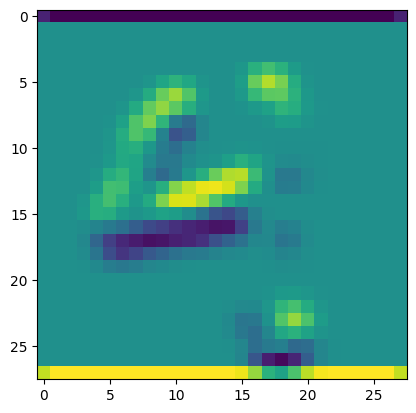

In [702]:
plt.imshow(Conv2d(data, Scharr_y, 1))

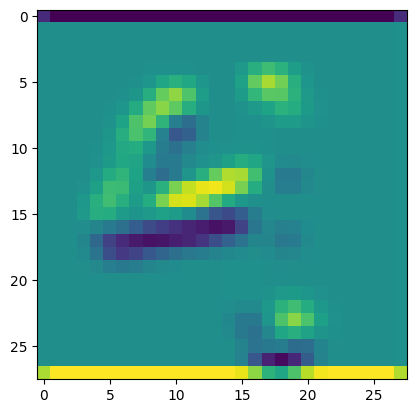

In [701]:
plt.imshow(Conv2d(data, kernel, 1))

In [854]:
l = np.zeros((500))
for i in range(500):
    x1 = Conv2d(data, kernel, 3)
    x2 = x1.reshape((4,28**2))
    x3 = Linear(x2, weights)
    x3max = np.abs(x3).max()
    x4 = Sigmoid(x3/x3max)
    x5 = MSE(x4, Y_e)
    l[i] = x5.sum()
    y1 = MSE_diff(x4, Y_e)
    y2 = Sigmoid_diff1(y1, x4)
    w, y3 = Linear_diff(y2, x2, weights)
    weights-=0.01*w.mean(0)
    y4 = y3.reshape((data.shape[0], 28, 28))
    k, _ = Conv2d_diff(y4, data, kernel, 3)
    kernel-=0.01*k.mean(0)[0]

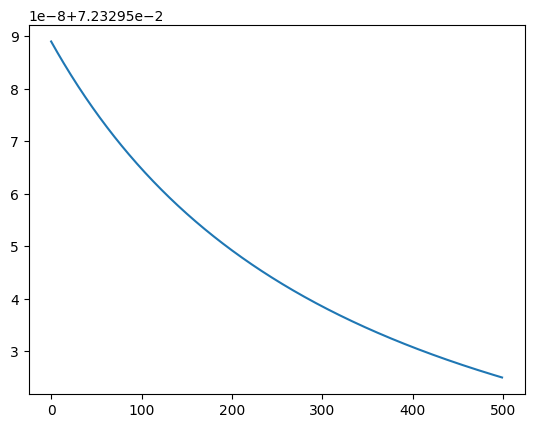

In [855]:
plt.plot(l);

In [747]:
x1 = Conv2d(data, kernel, 3)
x2 = x1.reshape((data.shape[0],28**2))
x3 = Linear(x2, weights)
x3max = np.abs(x3).max()
x4 = Sigmoid(x3/x3max)
x5 = MSE(x4, Y_e)
y1 = MSE_diff(x4, Y_e)
y2 = Sigmoid_diff1(y1, x3)
w, y3 = Linear_diff(y2, x2, weights)
y4 = y3.reshape((data.shape[0], 28, 28))
k, _ = Conv2d_diff(y4, data, kernel, 3)